In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
# import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict
from tqdm import tqdm

import polars as pl

In [2]:
from monk import utils, workflow

parent = pathlib.Path(os.getcwd()).parent.parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [5]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str
    iter: int

In [5]:
# get d2min distribution

# rev_quant = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue

    expers = sorted(glob.glob(job.fn("longest_experiments/*/*/traj_period-*.gsd"))) # traj-fire

    if len(expers) < 10:
        continue

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", "_")
        iter = utils.extract_between(exper, "iter-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep, iter=int(iter))
        out_path = f"longest_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob-coarse_period-{period}_iter-{iter}.parquet"
        
        if float(period) != 1000:
            continue

        # if job.isfile(out_path):
        #     continue

        print(sp)

        traj = gsd.hoomd.open(exper)

        frame_is = []
        frame_js = []
        ids = []
        msds = []
        ave_msds = []
        comp_start = lambda i: -1 + i*20
        for i in tqdm(range(1, 200, 400)):
            snap = traj[-1 + i*20]
            tags = np.arange(len(snap.particles.position))

            init_pos = snap.particles.position
            images = np.zeros_like(init_pos, dtype=np.int32)
            last_pos = init_pos.copy()
            freud_box = freud.box.Box.from_box(snap.configuration.box)
            center = init_pos.mean(axis=0)

            for j in range(i + 1, 200, 1):
                # print(j)
                frame_is.append(-1 + i*20)
                frame_js.append(-1 + j*20)

                snap_later = traj[-1 + j*20]

                box = snap.configuration.box[:]
                box_later = snap_later.configuration.box[:]
                ids.append(tags)

                # compute msd
                pos = snap_later.particles.position
                images -=  freud_box.get_images(pos - last_pos)
                last_pos = pos
                new_pos = freud_box.unwrap(pos, images)
                new_pos -= new_pos.mean(axis=0)
                msd = np.sum(np.square(new_pos - init_pos + center), axis=-1)
                ave_msds.append(np.mean(msd))
                msds.append(msd)
        
        dataset = pl.DataFrame({"frame_i": frame_is, "frame_j": frame_js, "id": ids, "msd": msds, "ave_msd": ave_msds})
        dataset.write_parquet(job.fn(out_path), use_pyarrow=True)
        msds = np.array(msds)
    #     break
    # break

634e14bc75836df75158fb15f379d8bb
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL', iter=0)


  0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [6]:
# get d2min distribution

# rev_quant = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue

    expers = sorted(glob.glob(job.fn("longest_experiments/*/*/"))) # traj-fire

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        # period = utils.extract_between(exper, "period-", "_")
        # iter = utils.extract_between(exper, "iter-", ".gsd")
        iter = 0
        temp = utils.extract_between(exper, "temp-", "/")
        period = 1000
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep, iter=int(iter))
        out_path = f"longest_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob-total_period-{period}.parquet"

        trajs = sorted(glob.glob(exper + "traj_period-*_iter*.gsd"))

        if len(trajs) == 0:
            continue

        # if len(trajs) < 10:
        #     trajs = trajs[:-1]
        # elif job.isfile(out_path):
        #     print("skipping", out_path)
        #     continue
        
        if float(period) != 1000:
            continue

        # print(trajs)
        # break

        print(sp)
        init_pos = None

        frame_is = []
        frame_js = []
        ids = []
        msds = []
        ave_msds = []
        comp_start = lambda i: -1 + i*20

        for exper_iter in trajs:
            iter = int(utils.extract_between(exper_iter, "iter-", ".gsd"))
            # print(exper_iter)
            traj = gsd.hoomd.open(exper_iter)

            i = 1
            if init_pos is None:
                snap = traj[-1 + i*20]
                tags = np.arange(len(snap.particles.position))

                init_pos = snap.particles.position
                images = np.zeros_like(init_pos, dtype=np.int32)
                last_pos = init_pos.copy()
                freud_box = freud.box.Box.from_box(snap.configuration.box)
                center = init_pos.mean(axis=0)

            for j in range(i, 200):
                # print(j)
                frame_is.append(-1 + i*20)
                frame_js.append(-1 + j*20 + iter*200*20)

                snap_later = traj[-1 + j*20]

                box = snap.configuration.box[:]
                box_later = snap_later.configuration.box[:]
                ids.append(tags)

                # compute msd
                pos = snap_later.particles.position
                images -=  freud_box.get_images(pos - last_pos)
                last_pos = pos
                new_pos = freud_box.unwrap(pos, images)
                new_pos -= new_pos.mean(axis=0)
                msd = np.sum(np.square(new_pos - init_pos + center), axis=-1)
                ave_msds.append(np.mean(msd))
                msds.append(msd)
        
        dataset = pl.DataFrame({"frame_i": frame_is, "frame_j": frame_js, "id": ids, "msd": msds, "ave_msd": ave_msds})
        dataset.write_parquet(job.fn(out_path), use_pyarrow=True)
        msds = np.array(msds)
    #     break
    # break

634e14bc75836df75158fb15f379d8bb
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL', iter=0)
7ec2f6aca035e69077eab24383a21cb6
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL', iter=0)
cfa1e4c0007fd65d020f809715a6f0b4
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL', iter=0)
ecce68c50e28a33684826f28780bf6e9
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL', iter=0)
1d0fe2ba44a6f635f5504dcbcee0ebc9
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL', iter=0)
1083a2a09eec2c6cf215ebc7a9706cac
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL', iter=0)
09d3dccc56f1fa9330b57901cd232ab7
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL', iter=0)
6976a7c10ada4159010403f8027f3ea5
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL', iter=0)
9158e73b2e4c9fd1a565e1e5d1bc3af5
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL', iter=0)
c

In [16]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue

    expers = sorted(glob.glob(job.fn("longest_experiments/*/*/traj_period-*.gsd")))

    for exper in tqdm(expers):
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", "_")
        iter = utils.extract_between(exper, "iter-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep, iter=int(iter))
        out_path = f"longest_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob-coarse_period-{period}_iter-{iter}.parquet"

        if job.isfile(out_path):
            dataset = pl.read_parquet(job.fn(out_path), columns=["frame_i", "frame_j", "ave_msd"])
            # dataset.drop_in_place("msd")
            # dataset.drop_in_place("id")
            output[sp].append(dataset)


634e14bc75836df75158fb15f379d8bb


100%|██████████| 10/10 [00:00<00:00, 345.33it/s]


7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4


100%|██████████| 10/10 [00:00<00:00, 27832.14it/s]


ecce68c50e28a33684826f28780bf6e9


100%|██████████| 10/10 [00:00<00:00, 27025.15it/s]


1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac


0it [00:00, ?it/s]


09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5


0it [00:00, ?it/s]


9158e73b2e4c9fd1a565e1e5d1bc3af5


0it [00:00, ?it/s]

c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


In [8]:
temps = set()
for key, data in output.items():
    # print(key.temp)
    temps.add(key.temp)
temps

{0.0019836}

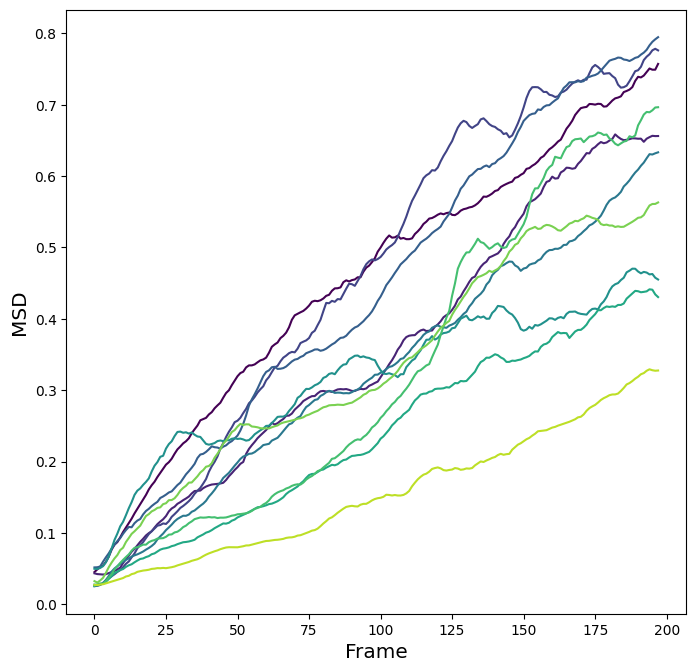

In [42]:
from scipy.ndimage import uniform_filter1d
from matplotlib import colors

fig = plt.figure(figsize=(8, 8), dpi=100)
# plt.gca().set_aspect('equal')

temps_loc = sorted(list(temps))

cmap = cm.viridis
# colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]
norm = colors.Normalize(vmin=0, vmax=10)

for key, data in output.items():
    pair = key.prep
    # print(key)
    if key.temp != temps_loc[0] or key.max_shear != 0.05:
        continue
    # print(key.temp)
    if pair == "ESL":
        ls = "-"
    else:
        ls = "-"
    # tws = [[], [], [], []]
    # colors = ["r", "b", "g", "k"]
    waits = [0, 50, 100, 150]
    # for d in data:
    tws = data[0]["ave_msd"].to_numpy()
            # break
    # tws = [np.mean(tw, axis=0) for tw in tws]
    # for tw, c, w in zip(tws, colors, waits):
    #     # get log-log slope
    tws = uniform_filter1d(tws, 10)
    #     x = np.log(np.arange(len(tw)))[20:]
    #     y = np.log(tw)[20:]
    #     slope = np.polyfit(x, y, 1)[0]
    #     print(slope)
    #     # plt.plot(x, y)
    c = cmap(norm(key.iter))
    plt.plot(tws, label=f"{pair}", ls=ls, color=c)
plt.ylabel("MSD", size="x-large")
plt.xlabel("Frame", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(title=r"prep, $t_w$, $D$", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.ylim(0, 0.05)
plt.savefig("msd-0.05-0.25-log.png", dpi=300, bbox_inches='tight')

In [6]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue

    expers = sorted(glob.glob(job.fn("longest_experiments/*/*")))

    for exper in tqdm(expers):
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = 1000
        # iter = utils.extract_between(exper, "iter-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep, iter=0)
        out_path = f"longest_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob-total_period-{period}.parquet"

        if job.isfile(out_path):
            dataset = pl.read_parquet(job.fn(out_path), columns=["frame_i", "frame_j", "ave_msd"])
            # dataset.drop_in_place("msd")
            # dataset.drop_in_place("id")
            output[sp].append(dataset)


634e14bc75836df75158fb15f379d8bb


100%|██████████| 1/1 [00:00<00:00, 16.60it/s]


7ec2f6aca035e69077eab24383a21cb6


100%|██████████| 1/1 [00:00<00:00, 37.62it/s]


cfa1e4c0007fd65d020f809715a6f0b4


100%|██████████| 1/1 [00:00<00:00, 66.05it/s]

ecce68c50e28a33684826f28780bf6e9



100%|██████████| 1/1 [00:00<00:00, 40.55it/s]


1d0fe2ba44a6f635f5504dcbcee0ebc9


100%|██████████| 1/1 [00:00<00:00, 39.78it/s]


1083a2a09eec2c6cf215ebc7a9706cac


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


09d3dccc56f1fa9330b57901cd232ab7


100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


6976a7c10ada4159010403f8027f3ea5


100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


9158e73b2e4c9fd1a565e1e5d1bc3af5


100%|██████████| 1/1 [00:00<00:00, 47.14it/s]


c6d7afd0de62bfa16d05da47815227eb


100%|██████████| 1/1 [00:00<00:00, 41.83it/s]


bf92a185d043ce3ef666e05e427c7e76


100%|██████████| 1/1 [00:00<00:00, 29.82it/s]


a8f2c249ed85533b56b0729b7ab96d18


100%|██████████| 1/1 [00:00<00:00, 146.80it/s]


In [7]:
temps = set()
for key, data in output.items():
    # print(key.temp)
    temps.add(key.temp)
temps

{0.0019836}

/tmp/ipykernel_1774323/1571026009.py:42: RuntimeWarning: divide by zero encountered in log
  x = np.log(np.arange(len(tw)))[200:2000]


HTL 0.8625570757236323
ESL 1.0499175821528768


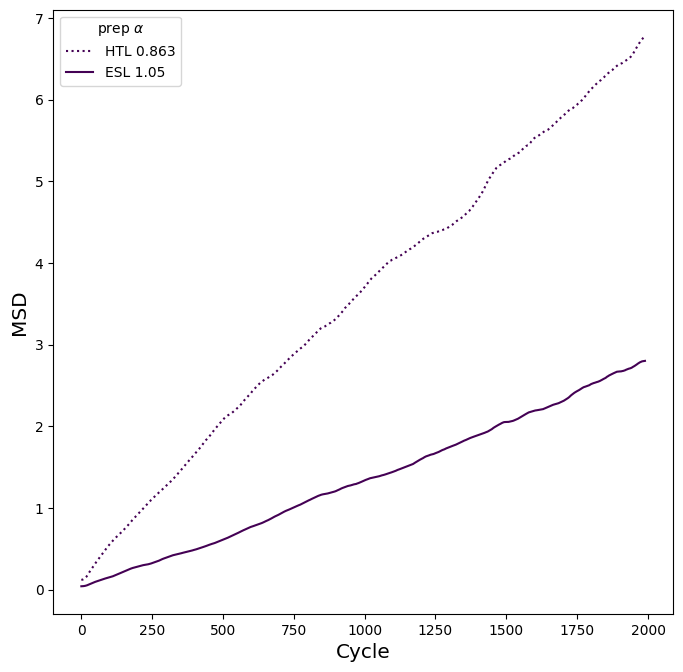

In [16]:
from scipy.ndimage import uniform_filter1d
from matplotlib import colors

fig = plt.figure(figsize=(8, 8), dpi=100)
# plt.gca().set_aspect('equal')

temps_loc = sorted(list(temps))

cmap = cm.viridis
# colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]
norm = colors.Normalize(vmin=0, vmax=10)

for key, data in output.items():
    prep = key.prep
    # print(key)
    if key.temp != temps_loc[0] or key.max_shear != 0.05:
        continue
    # print(key.temp)
    if prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    # tws = [[], [], [], []]
    # colors = ["r", "b", "g", "k"]
    waits = [0, 50, 100, 150]
    # for d in data:
    ds = []
    m = 2000
    for d in data:
        if len(d) == 0:
            continue
        ds.append(d["ave_msd"].to_numpy())
        
        m = min(m, len(d))
                # break
        # tws = [np.mean(tw, axis=0) for tw in tws]
        # for tw, c, w in zip(tws, colors, waits):
        #     # get log-log slope
    ds = [d[:m] for d in ds]
    tws = np.mean(ds, axis=0)
    tw = uniform_filter1d(tws, 50)
    x = np.log(np.arange(len(tw)))[200:2000]
    y = np.log(tw)[200:2000]
    slope = np.polyfit(x, y, 1)[0]
    print(prep, slope)
    #     # plt.plot(x, y)
    c = cmap(norm(key.iter))
    x  = np.arange(len(tw))
    plt.plot(x[1:], tw[1:], label=f"{prep} {slope:.3}", ls=ls, color=c)
plt.ylabel("MSD", size="x-large")
plt.xlabel("Cycle", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
plt.legend(title=r"prep $\alpha$")
# plt.ylim(0, 0.05)
plt.savefig("msd-0.05-0.25-log.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_9775/2377821428.py:42: RuntimeWarning: divide by zero encountered in log
  x = np.log(np.arange(len(tw)))[200:2000]


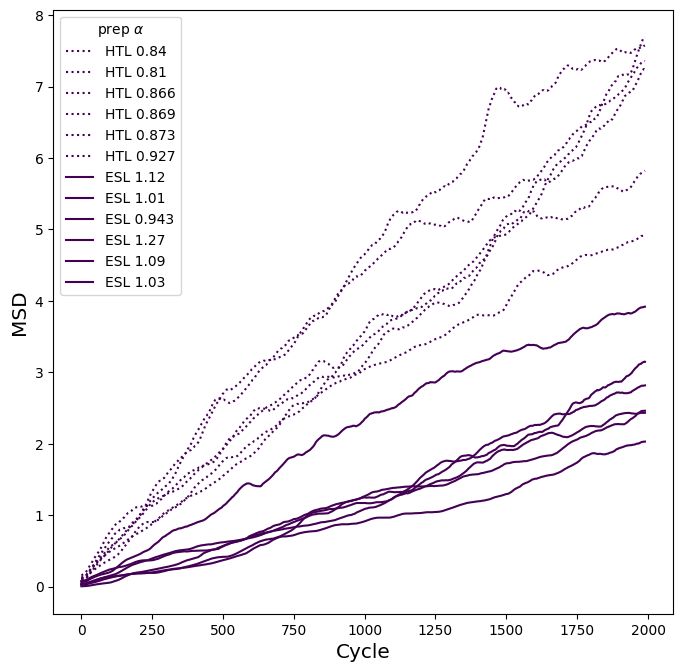

In [9]:

from scipy.ndimage import uniform_filter1d
from matplotlib import colors

fig = plt.figure(figsize=(8, 8), dpi=100)
# plt.gca().set_aspect('equal')

temps_loc = sorted(list(temps))

cmap = cm.viridis
# colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]
norm = colors.Normalize(vmin=0, vmax=10)

for key, data in output.items():
    prep = key.prep
    # print(key)
    if key.temp != temps_loc[0] or key.max_shear != 0.05:
        continue
    # print(key.temp)
    if prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    # tws = [[], [], [], []]
    # colors = ["r", "b", "g", "k"]
    waits = [0, 50, 100, 150]
    # for d in data:
    # ds = []
    m = 2000
    for d in data:
        if len(d) == 0:
            continue
        tws = d["ave_msd"].to_numpy()
        
        # m = min(m, len(d))
                # break
        # tws = [np.mean(tw, axis=0) for tw in tws]
        # for tw, c, w in zip(tws, colors, waits):
        #     # get log-log slope
        # ds = [d[:m] for d in ds]
        # tws = np.mean(ds, axis=0)
        tw = uniform_filter1d(tws, 50)
        x = np.log(np.arange(len(tw)))[200:2000]
        y = np.log(tw)[200:2000]
        slope = np.polyfit(x, y, 1)[0]
        # print(prep, slope)
        #     # plt.plot(x, y)
        c = cmap(norm(key.iter))
        x  = np.arange(len(tw))
        plt.plot(x[1:], tw[1:], label=f"{prep} {slope:.3}", ls=ls, color=c)
plt.ylabel("MSD", size="x-large")
plt.xlabel("Cycle", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
plt.legend(title=r"prep $\alpha$")
# plt.ylim(0, 0.05)
# plt.savefig("msd-0.05-0.25-log.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_3002928/2303481259.py:34: RuntimeWarning: divide by zero encountered in log
  x = np.log(np.arange(len(tw)))[20:]


0.8387129180496712
0.9499162669099946
0.9171837044278117
1.0820828431412617
0.9492625918018598
1.0595681794542573
0.947315954092818
0.8953260639860803


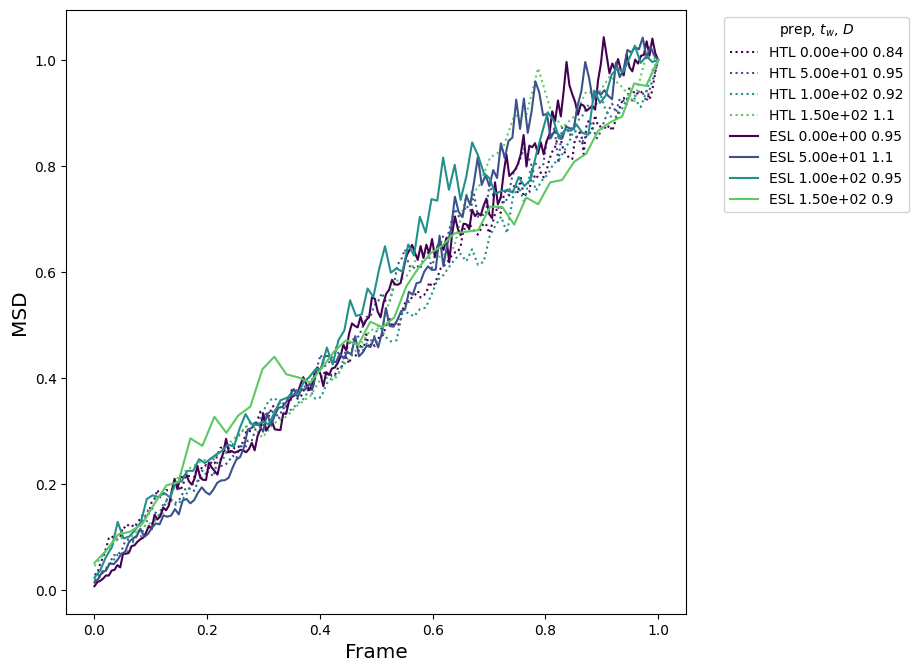

In [53]:
from scipy.ndimage import uniform_filter1d

fig = plt.figure(figsize=(8, 8), dpi=100)
# plt.gca().set_aspect('equal')

temps_loc = sorted(list(temps))

cmap = cm.viridis
colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]

for key, data in output.items():
    pair = key.prep
    # print(key)
    if key.temp != temps_loc[-1] or key.max_shear != 0.05:
        continue
    # print(key.temp)
    if pair == "ESL":
        ls = "-"
    else:
        # continue
        ls = ":"
    tws = [[], [], [], []]
    # colors = ["r", "b", "g", "k"]
    waits = [0, 50, 100, 150]
    for d in data:
        for idx, (_, di) in enumerate(d.group_by("frame_i", maintain_order=True)):
            # print(idx)
            tws[idx].append(di[:]["ave_msd"].to_numpy())
            # break
    tws = [np.mean(tw, axis=0) for tw in tws]
    for tw, c, w in zip(tws, colors, waits):
        # get log-log slope
        # tw = uniform_filter1d(tw, 1)
        x = np.log(np.arange(len(tw)))[20:]
        y = np.log(tw)[20:]
        slope = np.polyfit(x, y, 1)[0]
        print(slope)
        # plt.plot(x, y)
        plt.plot(np.linspace(0, 1, len(tw)), tw/tw[-1], label=f"{pair} {w:.2e} {slope:.2}", ls=ls, color=c)
plt.ylabel("MSD", size="x-large")
plt.xlabel("Frame", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
plt.legend(title=r"prep, $t_w$, $D$", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.ylim(0, 0.05)
plt.savefig("msd-0.05-0.25.png", dpi=300, bbox_inches='tight')

In [101]:
esl_dataset["msd_ave"]

ColumnNotFoundError: msd_ave

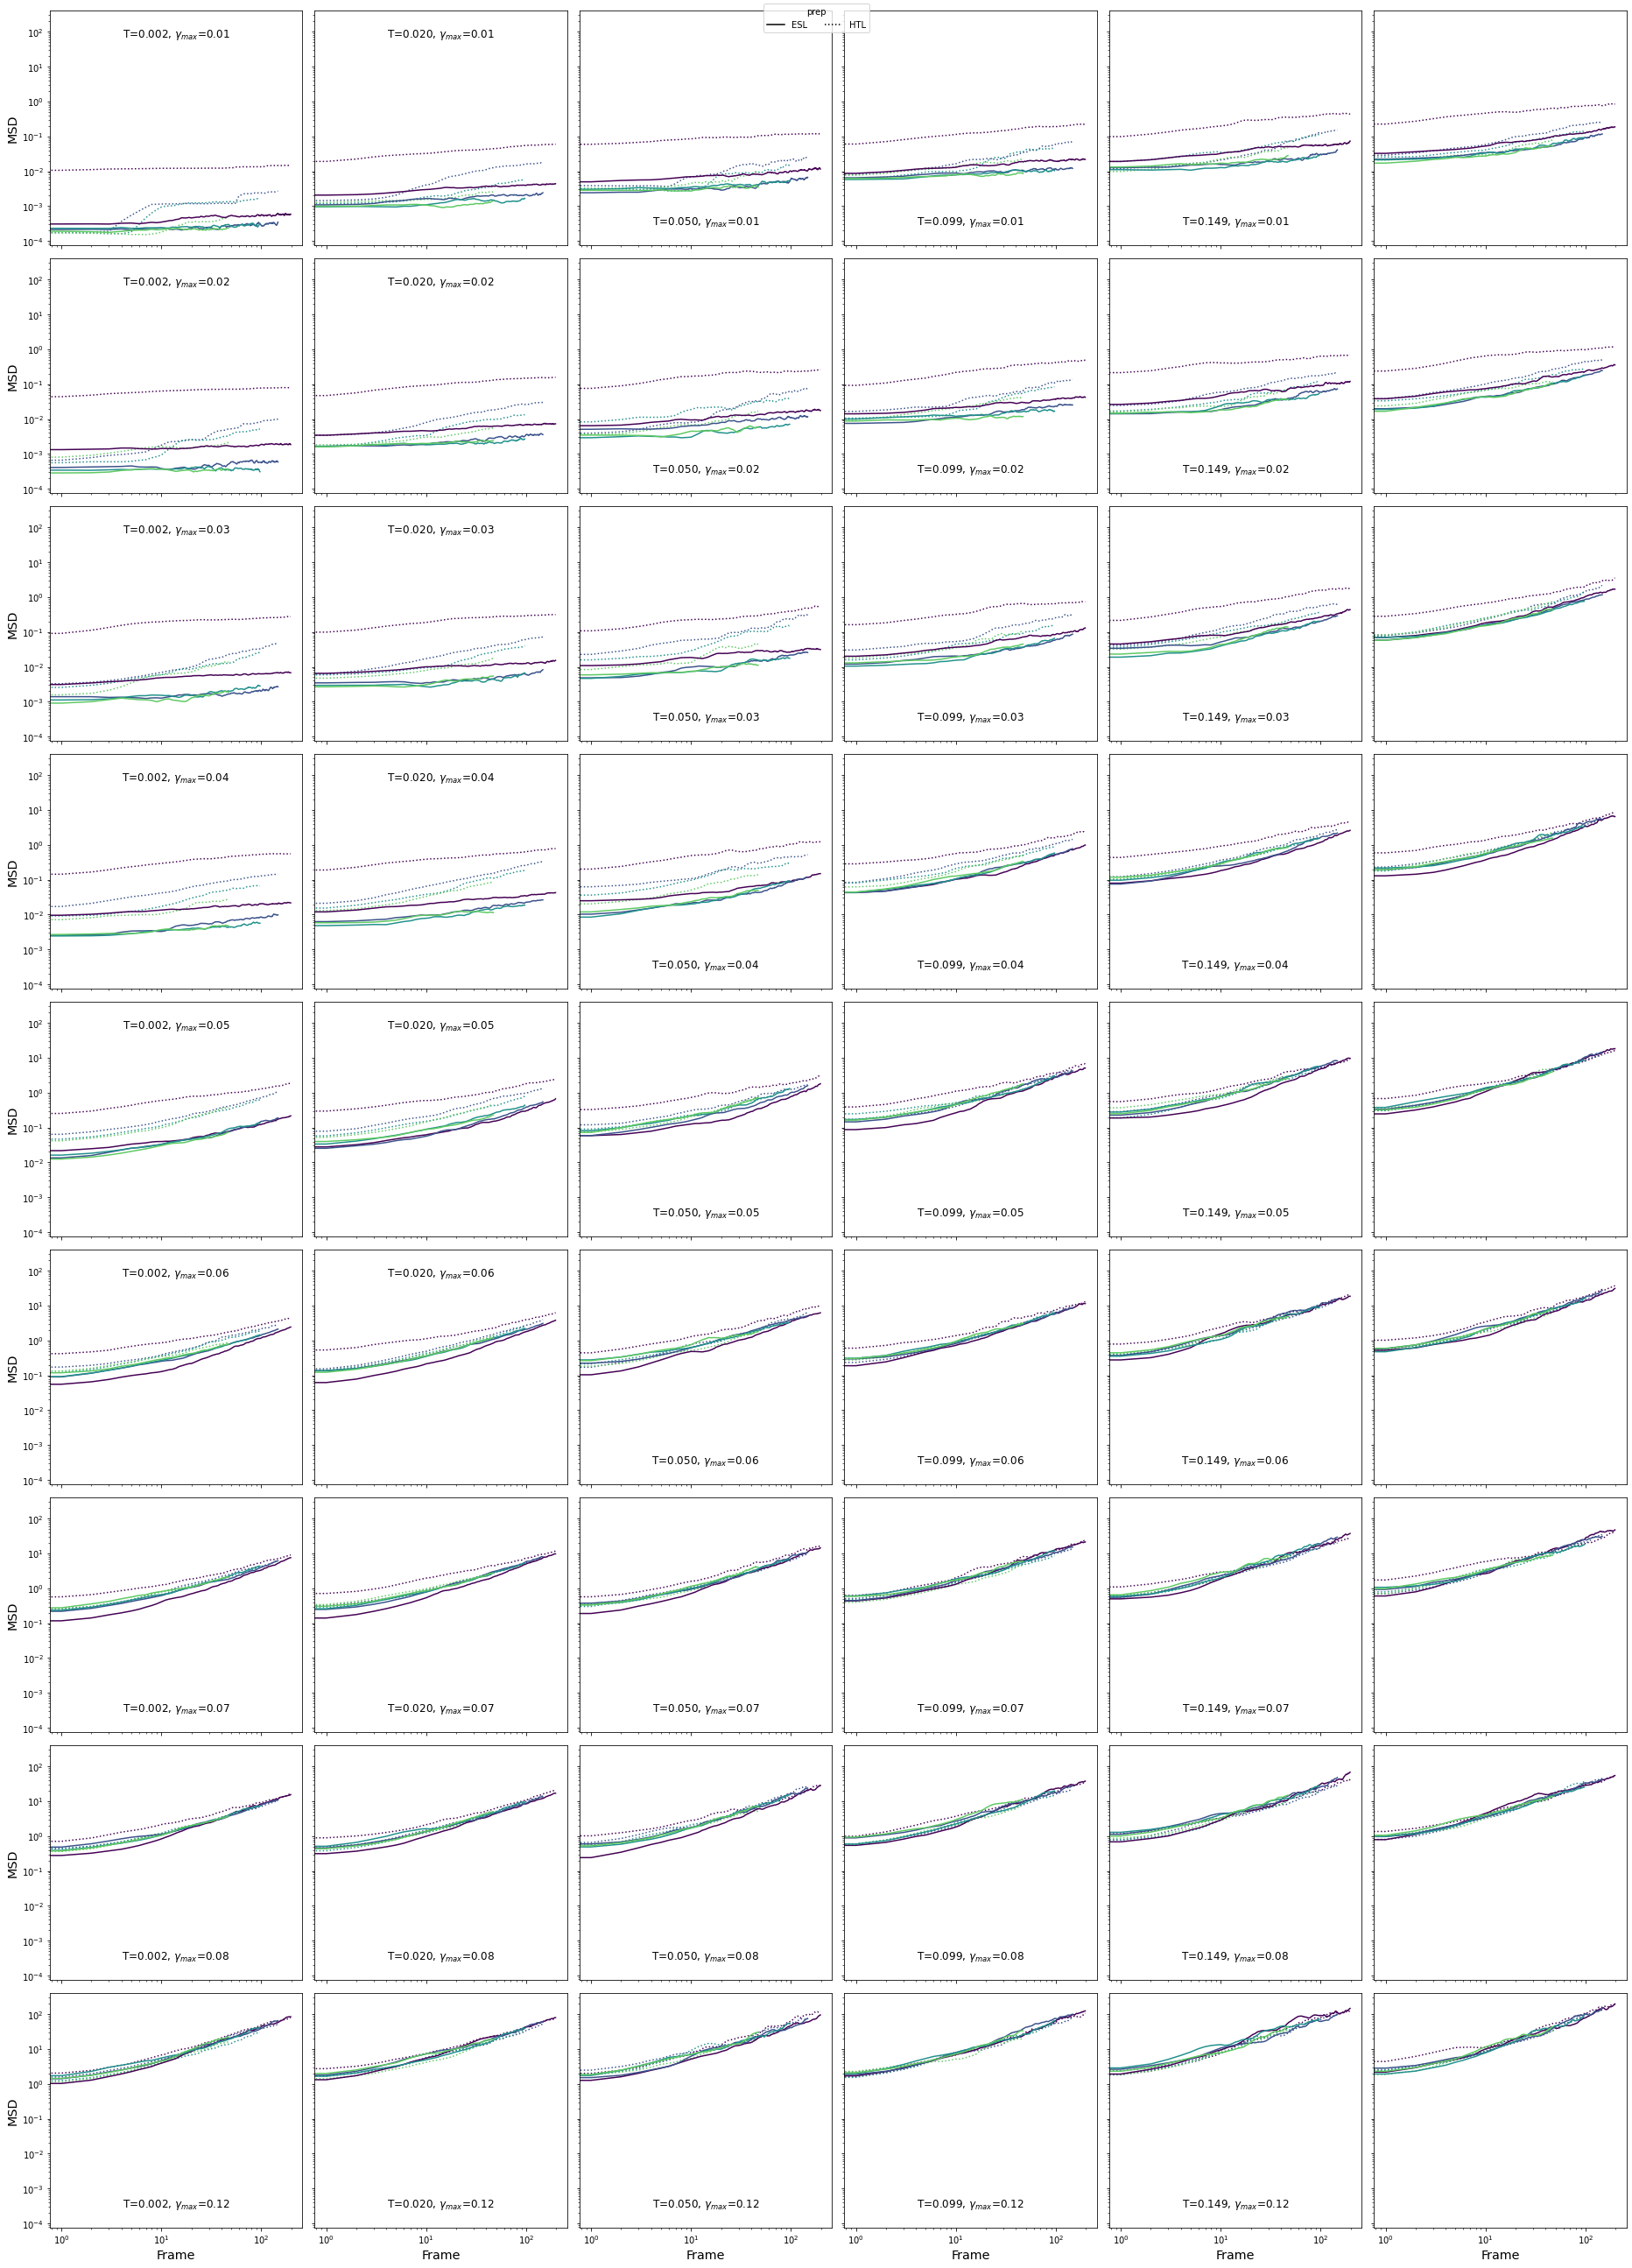

In [57]:
from scipy.ndimage import uniform_filter1d

temps = [0.0019836, 0.019836, 0.049591, 0.099182, 0.14877,  0.19836]
shears = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.12]

cmap = cm.viridis

fig, axs = plt.subplots(9, 6, figsize=(26, 36), sharex=True, sharey=True)

colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]

for key, data in output.items():
    pair = key.prep
    # print(key)
    # if key.temp != temps[1] or key.max_shear != 0.04:
    #     continue
    # print(key.temp)
    if pair == "ESL":
        ls = "-"
    else:
        ls = ":"
    tws = [[], [], [], []]
    i = temps.index(key.temp)
    j = shears.index(key.max_shear)
    for d in data:
        for idx, (_, di) in enumerate(d.group_by("frame_i", maintain_order=True)):
            # print(idx)
            tws[idx].append(di[:]["ave_msd"].to_numpy())
            # break
    tws = [np.mean(tw, axis=0) for tw in tws]
    for tw, c in zip(tws, colors):
        axs[j, i].plot(uniform_filter1d(tw, 5), label=f"{pair}", ls=ls, color=c)
# plt.ylabel("MSD", size="x-large")
# plt.xlabel("Frame", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(title="prep")
# plt.ylim(0, 0.05)
for ax in axs.ravel():
    ax.set_yscale('log')
    ax.set_xscale('log')

for ax in axs[-1, :]:
    ax.set_xlabel("Frame", size="x-large")

for ax in axs[:, 0]:
    ax.set_ylabel("MSD", size="x-large")

for i in range(5):
    for j in range(9):
        if i < 2 and j < 6:
            pos = (0.5, 0.9)
        else:
            pos = (0.5, 0.1)
        axs[j, i].text(*pos, fr"T={temps[i]:.3f}, $\gamma_{{max}}$={shears[j]}", transform=axs[j, i].transAxes, ha="center", va="center", size="large")

handles = [mpl.lines.Line2D([0], [0], color="k", linestyle="-", label="ESL"), mpl.lines.Line2D([0], [0], color="k", linestyle=":", label="HTL")]

fig.legend(handles=handles, title="prep", loc='upper center', ncol=2)

plt.tight_layout()

plt.savefig("big-msd.png", dpi=300)

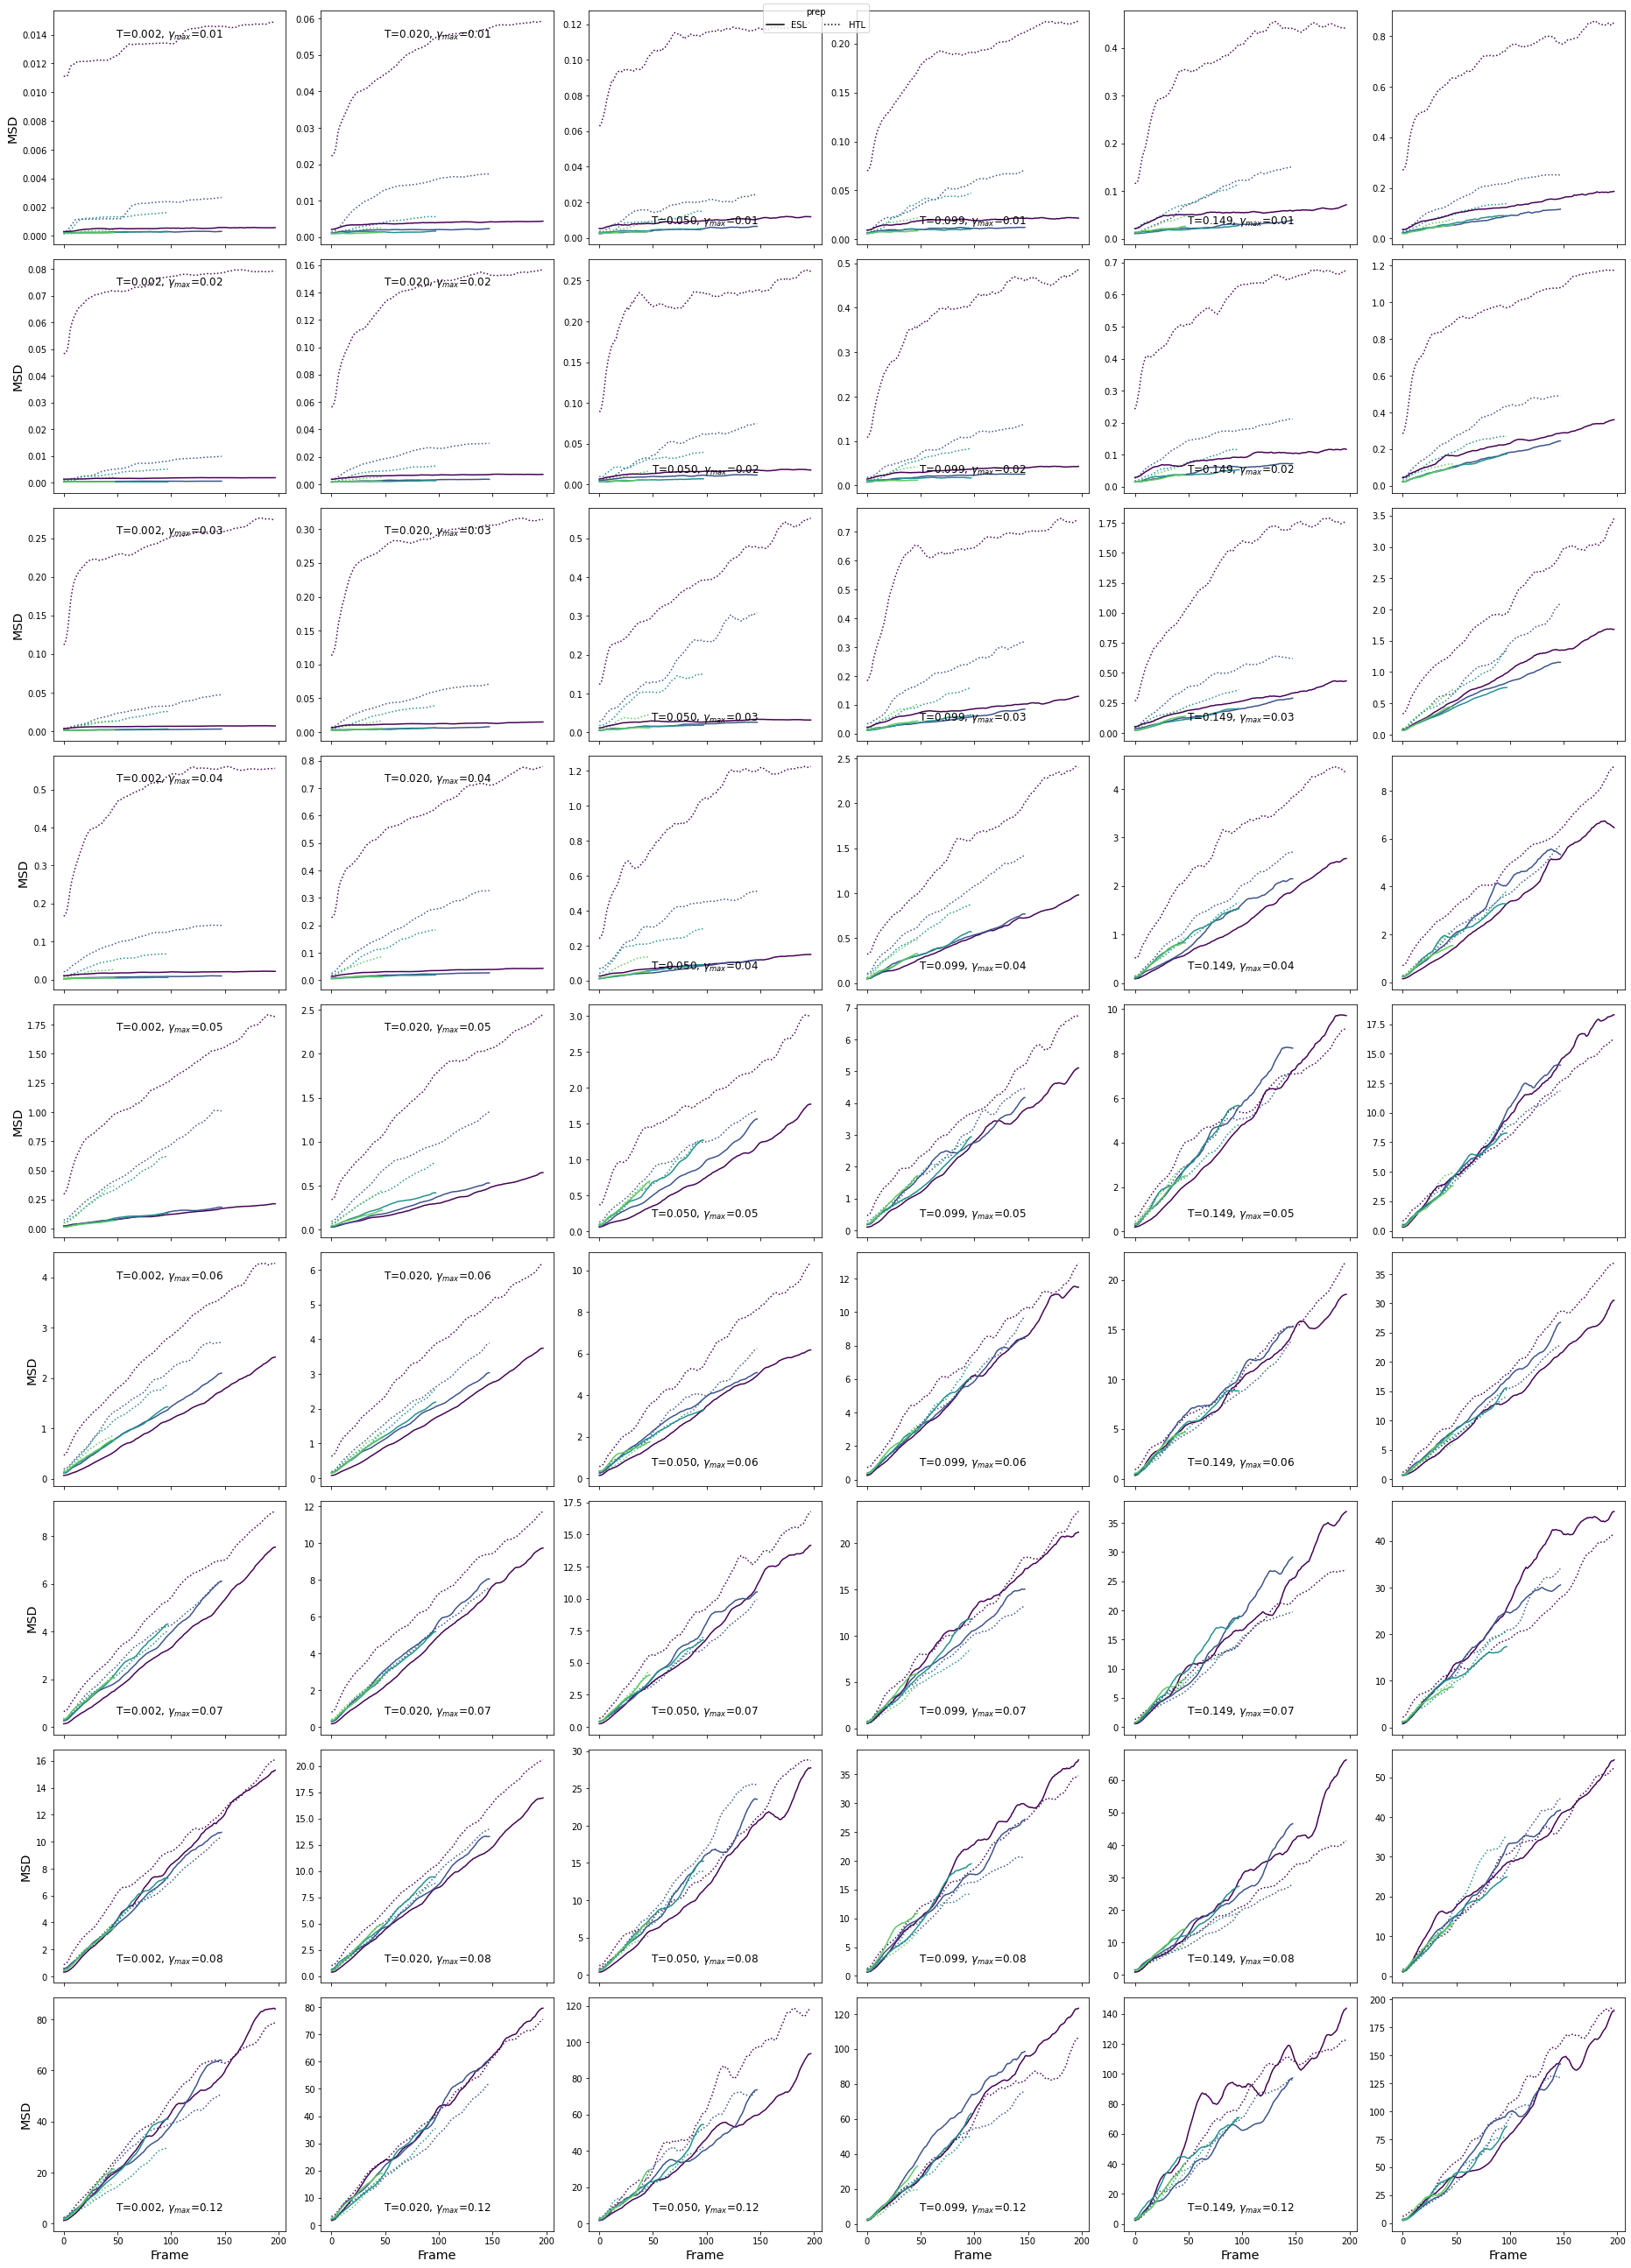

In [18]:
from scipy.ndimage import uniform_filter1d

temps = [0.0019836, 0.019836, 0.049591, 0.099182, 0.14877,  0.19836]
shears = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.12]

cmap = cm.viridis

fig, axs = plt.subplots(9, 6, figsize=(26, 36), sharex=True)

colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]

for key, data in output.items():
    pair = key.prep
    # print(key)
    # if key.temp != temps[1] or key.max_shear != 0.04:
    #     continue
    # print(key.temp)
    if pair == "ESL":
        ls = "-"
    else:
        ls = ":"
    tws = [[], [], [], []]
    i = temps.index(key.temp)
    j = shears.index(key.max_shear)
    for d in data:
        for idx, (_, di) in enumerate(d.group_by("frame_i", maintain_order=True)):
            # print(idx)
            tws[idx].append(di[:]["ave_msd"].to_numpy())
            # break
    tws = [np.mean(tw, axis=0) for tw in tws]
    for tw, c in zip(tws, colors):
        axs[j, i].plot(uniform_filter1d(tw, 10), label=f"{pair}", ls=ls, color=c)
# plt.ylabel("MSD", size="x-large")
# plt.xlabel("Frame", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(title="prep")
# plt.ylim(0, 0.05)
# for ax in axs.ravel():
#     ax.set_yscale('log')
#     ax.set_xscale('log')

for ax in axs[-1, :]:
    ax.set_xlabel("Frame", size="x-large")

for ax in axs[:, 0]:
    ax.set_ylabel("MSD", size="x-large")

for i in range(5):
    for j in range(9):
        if i < 2 and j < 6:
            pos = (0.5, 0.9)
        else:
            pos = (0.5, 0.1)
        axs[j, i].text(*pos, fr"T={temps[i]:.3f}, $\gamma_{{max}}$={shears[j]}", transform=axs[j, i].transAxes, ha="center", va="center", size="large")

handles = [mpl.lines.Line2D([0], [0], color="k", linestyle="-", label="ESL"), mpl.lines.Line2D([0], [0], color="k", linestyle=":", label="HTL")]

fig.legend(handles=handles, title="prep", loc='upper center', ncol=2)

plt.tight_layout()

plt.savefig("big-msd-linear.png", dpi=300)

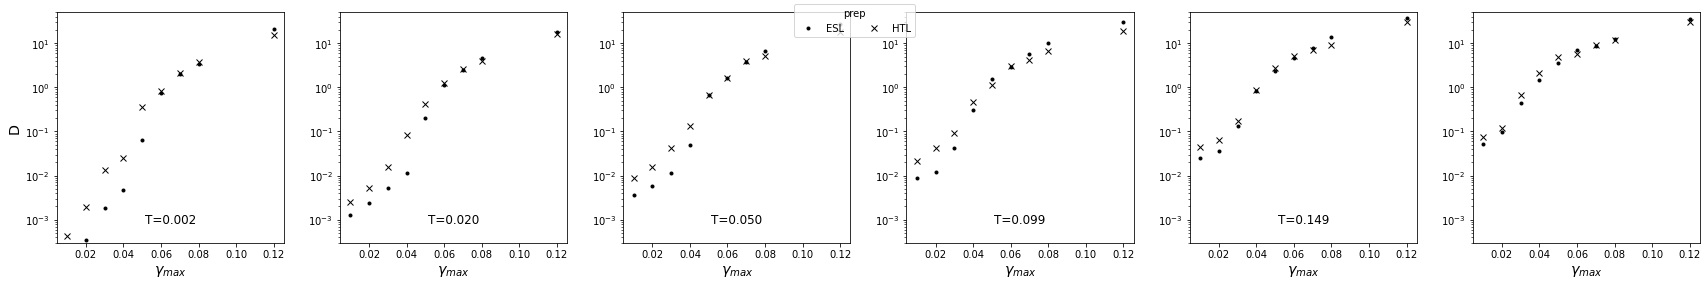

In [19]:
from scipy.ndimage import uniform_filter1d

temps = [0.0019836, 0.019836, 0.049591, 0.099182, 0.14877,  0.19836]
shears = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.12]

cmap = cm.viridis

fig, axs = plt.subplots(1, 6, figsize=(24, 4), sharex=True)

colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]

for key, data in output.items():
    pair = key.prep
    # print(key)
    # if key.temp != temps[1] or key.max_shear != 0.04:
    #     continue
    # print(key.temp)
    if pair == "ESL":
        ls = "."
    else:
        ls = "x"
    tws = [[], [], [], []]
    i = temps.index(key.temp)
    j = shears.index(key.max_shear)
    for d in data:
        for idx, (_, di) in enumerate(d.group_by("frame_i", maintain_order=True)):
            # print(idx)
            tws[idx].append(di[:]["ave_msd"].to_numpy())
            # break
    tws = [np.mean(tw, axis=0) for tw in tws]
    # for tw, c in zip(tws, colors):
    # axs[j, i].plot(uniform_filter1d(tw, 10), label=f"{pair}", ls=ls, color=c)
    axs[i].plot(key.max_shear, uniform_filter1d(tws[-1], 20)[-1], ls, label=f"{pair}", color="k")
# plt.ylabel("MSD", size="x-large")
# plt.xlabel("Frame", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(title="prep")
# plt.ylim(0, 0.05)
for ax in axs.ravel():
    ax.set_yscale('log')
    # ax.set_xscale('log')

# for ax in axs[-1, :]:
#     ax.set_xlabel("Frame", size="x-large")

# for ax in axs[:, 0]:
#     ax.set_ylabel("MSD", size="x-large")

for i in range(5):
    pos = (0.5, 0.1)
    axs[i].text(*pos, f"T={temps[i]:.3f}", transform=axs[i].transAxes, ha="center", va="center", size="large")

# handles = [mpl.lines.Line2D([0], [0], color="k", linestyle="-", label="ESL"), mpl.lines.Line2D([0], [0], color="k", linestyle=":", label="HTL")]

# fig.legend(handles=handles, title="prep", loc='upper center', ncol=2)

# plt.tight_layout()

# plt.savefig("big-msd.png", dpi=300)
axs[0].set_ylabel("D", size="x-large")
for ax in axs:
    ax.set_xlabel(r"$\gamma_{max}$", size="x-large")
    ax.set_ylim(3e-4, 5e1)

handles = [mpl.lines.Line2D([0], [0], color="k", linestyle="", marker=".", label="ESL"), mpl.lines.Line2D([0], [0], color="k", marker="x", linestyle="", label="HTL")]

fig.legend(handles=handles, title="prep", loc='upper center', ncol=2)

plt.tight_layout()

plt.savefig("diffusion.png", dpi=300)